<a href="https://colab.research.google.com/github/maxxies/news-classifier/blob/model/New_Articles_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install xplore     # exploring features of a dataset in minimal number of lines of code

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for xplore: filename=xplore-0.0.1-py3-none-any.whl size=4195 sha256=b088eda4275b78b804302b08c595d3d7bfcf9a12cfa2178339195b1a3d29f516
  Stored in directory: /root/.cache/pip/wheels/8f/ee/9f/dc64edd7cbc7d72291f309afa83bcb8258ada61b2445a7b2cf
Successfully built xplore


# Libraries 

In [ ]:
import pandas as pd                  # data processing
from glob import glob as gb          # return all file paths that match a specific pattern.
import seaborn as sns              #Visualization
import os
import json
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud     #nice library to produce wordclouds
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import warnings
from collections import defaultdict
from collections import Counter

warnings.simplefilter('ignore')
pd.set_option('display.max_columns', 500)


# Reading data



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pathname ='/content/gdrive/MyDrive/news-articles'  # path to folder where json files are stored
all_files = gb(os.path.join(pathname,'*.json'))  # reads all .json files
dfs=[]                    # stores all read .json files
for file in all_files:
  with open(file, 'r') as f:
    json_data = pd.json_normalize(json.loads(f.read()))   # reads all .json file into Dateframe
    dfs.append(json_data)

df = pd.concat(dfs, ignore_index=True, sort=False)    # combine all read .json files into one Dataframe
df.head(5)  # shows first items in the table

,id,source,publishDate,title,body
0,a-162434770831,Yahoo! News,2019-05-08T00:00:00Z,Why Shares of MACOM Technology Jumped Today,What happened\nShares of MACOM Technology Solu...
1,a-7897928149,BBC News,2019-06-24T00:00:00Z,Wainfleet flooding: Clean-up 'could take months',Volunteers are being sought to put a flooded t...
2,a-161599088517,Yahoo! News,2018-03-19T00:00:00Z,Beyond Factor Fundamentals – Are You Ready to ...,The fixed-income market is likely heading towa...
3,a-164331704786,BBC News,2018-11-05T00:00:00Z,Beavers return to Essex after 400 years to sto...,Beavers will be reintroduced to Essex more tha...
4,a-100857098697,Reuters,2019-07-03T22:35:32Z,Boeing makes $100 million pledge for 737 MAX c...,Boeing Co said on Wednesday it would give $100...


In [ ]:
df.info() # information on data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           3454 non-null   object
 1   source       3453 non-null   object
 2   publishDate  3454 non-null   object
 3   title        3454 non-null   object
 4   body         3454 non-null   object
dtypes: object(5)
memory usage: 135.0+ KB


In [ ]:
print('Shape of data: ',df.shape) # Shape of data

Shape of data:  (3454, 5)


In [ ]:
df.drop_duplicates(inplace=True)   # drop duplicates if any
#drop missing values
df.dropna(inplace=True)
print('New shape of data: ',df.shape) # Shape of data 

New shape of data:  (3453, 5)


In [ ]:
df.describe() # statitics on data

,id,source,publishDate,title,body
count,3453,3453,3453,3453,3453
unique,3453,561,2446,3370,3453
top,a-162434770831,Reuters,2019-06-27T00:00:00Z,CNN NEWSROOM,What happened\nShares of MACOM Technology Solu...
freq,1,600,19,19,1


In [ ]:
from xplore.data import xplore
xplore(df)
# select no

------------------------------------
The fist 5 entries of your dataset are:

               id       source           publishDate  \
0  a-162434770831  Yahoo! News  2019-05-08T00:00:00Z   
1    a-7897928149     BBC News  2019-06-24T00:00:00Z   
2  a-161599088517  Yahoo! News  2018-03-19T00:00:00Z   
3  a-164331704786     BBC News  2018-11-05T00:00:00Z   
4  a-100857098697      Reuters  2019-07-03T22:35:32Z   

                                               title  \
0        Why Shares of MACOM Technology Jumped Today   
1   Wainfleet flooding: Clean-up 'could take months'   
2  Beyond Factor Fundamentals – Are You Ready to ...   
3  Beavers return to Essex after 400 years to sto...   
4  Boeing makes $100 million pledge for 737 MAX c...   

                                                body  
0  What happened\nShares of MACOM Technology Solu...  
1  Volunteers are being sought to put a flooded t...  
2  The fixed-income market is likely heading towa...  
3  Beavers will be reintrodu

# Text Procesing and Data Cleaning

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


def preprocess(raw_text):

    #regular expression keeping only letters 
    only_letters = re.sub('[^a-zA-Z]', ' ', str(raw_text))   # removes characters other than letters
    cleaned_letters =re.sub('^, ',' ',str(only_letters))         # removes words with preceeding ','

    # convert to lower case and split into words
    words = cleaned_letters.lower().split(' ')
    
    lemmatizer = WordNetLemmatizer() 
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_words= [w for w in words if not w in stop_words]

    # Remove meaningless expressions
    cleaned_words = [word for word in cleaned_words if (len(word)>2)]
    
    # lemmatise words
    lemmatized_words = []
    for word in cleaned_words:
        word = lemmatizer.lemmatize(word)   #dont forget to change stem to lemmatize if you are using a lemmatizer
        lemmatized_words.append(word)
      
    # converting list back to string
    return " ".join(lemmatized_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df['prepared_body'] = df['body'].apply(preprocess)  
df.head()

,id,source,publishDate,title,body,prepared_body
0,a-162434770831,Yahoo! News,2019-05-08T00:00:00Z,Why Shares of MACOM Technology Jumped Today,What happened\nShares of MACOM Technology Solu...,happened share macom technology solution holdi...
1,a-7897928149,BBC News,2019-06-24T00:00:00Z,Wainfleet flooding: Clean-up 'could take months',Volunteers are being sought to put a flooded t...,volunteer sought put flooded town back foot cl...
2,a-161599088517,Yahoo! News,2018-03-19T00:00:00Z,Beyond Factor Fundamentals – Are You Ready to ...,The fixed-income market is likely heading towa...,fixed income market likely heading toward end ...
3,a-164331704786,BBC News,2018-11-05T00:00:00Z,Beavers return to Essex after 400 years to sto...,Beavers will be reintroduced to Essex more tha...,beaver reintroduced essex year hunted extincti...
4,a-100857098697,Reuters,2019-07-03T22:35:32Z,Boeing makes $100 million pledge for 737 MAX c...,Boeing Co said on Wednesday it would give $100...,boeing said wednesday would give million multi...


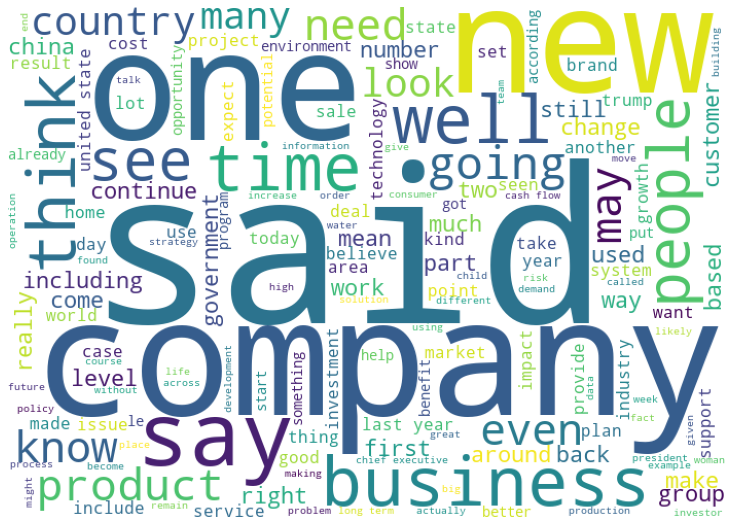

In [ ]:
%matplotlib inline
all_words = '' 
vocab = []

#looping through all incidents and joining them to one text, to extract most common words
for arg in df["prepared_body"]: 
    tokens = arg.split()  
    vocab.append(tokens)
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(all_words) 

# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
def generate_wordcloud(list_, source):
    #convert list to string
    unique_string=(" ").join(list_)
   
    wordcloud = WordCloud(width = 2000, height = 500, background_color="white").generate(unique_string)
    
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()    
    plt.close()    
    return


In [ ]:
new_df =pd.DataFrame()
# Wordcloud for each source
count =1
from PIL import Image
for source in df.source.unique():
  print('WordCloud for {} ->{}'.format(source,count))
  tmp_df = df[df['source']==source]['prepared_body']
  new_df['source']=source
  new_df['body']=(" ").join(tmp_df)
  generate_wordcloud(tmp_df, source)
  count=count+1



In [ ]:
new_df.info()
new_df.head(10)

# Sentiment Analysis

In [ ]:
%pip install transformers==3.1.0

In [ ]:
from transformers import pipeline
classifier =pipeline('zero-shot-classification')

In [ ]:
def SentimentAnalyser(data):
    labels=['governance','social','environmental']
    sentiments = classifier(data,labels)
    # print(sentiments)

    # df[sentiments['labels'][0]]=sentiments['scores'][0]
    # df[sentiments['labels'][1]]=sentiments['scores'][1]
    # df[sentiments['labels'][2]]=sentiments['scores'][2]

    # return df

    a= sentiments['scores'][sentiments['labels'].index('social')]
    b=sentiments['scores'][sentiments['labels'].index('governance')]
    c=sentiments['scores'][sentiments['labels'].index('environmental')]

    return a,b,c

In [ ]:
new_df[['social','governance','environmental']]=new_df['prepared_body'].apply(lambda x: SentimentAnalyser(x))  


# Data Visualisations

In [ ]:
# Bar plot showing Environmental analysis for each source
plt.rcParams["figure.figsize"] = (18, 10)

weekly_total_traffic = new_df.groupby(["source"])["environmental"].mean()

plt.bar(weekly_total_traffic.index, weekly_total_traffic, color="orange")
plt.xlabel('Sources')  # Labeling x axis
plt.ylabel('Environmetal Sentiment Scores')# labeling y axis
plt.title('Environmental Analysis')
plt.show()

In [ ]:
# Bar plot showing Social analysis for each source
plt.rcParams["figure.figsize"] = (18, 10)

weekly_total_traffic = new_df.groupby(["source"])["social"].mean()

plt.bar(weekly_total_traffic.index, weekly_total_traffic, color="orange")
plt.xlabel('Sources')  # Labeling x axis
plt.ylabel('Social Sentiment Scores')# labeling y axis
plt.title('Social Analysis')
plt.show()

In [ ]:
# Bar plot showing Governance analysis for each source
plt.rcParams["figure.figsize"] = (18, 10)

weekly_total_traffic = new_df.groupby(["source"])["governance"].mean()

plt.bar(weekly_total_traffic.index, weekly_total_traffic, color="orange")
plt.xlabel('Sources')  # Labeling x axis
plt.ylabel('Governance Sentiment Scores')# labeling y axis
plt.title('Governance Analysis')
plt.show()